In [1]:
%matplotlib inline

import numpy as np
import copy
import matplotlib.pyplot as plt
import pickle
import random
import torch
from utils import torch_from_numpy
import datetime

from config import cfg_seed, cfg_env, cfg_z_dim, cfg_alpha
seed = cfg_seed


# bif_c = 0.1
num_iter_max=200000
# alpha=0.2
alpha=cfg_alpha
vae_lr=5e-4
ratio_lr=5e-4
ratio_early=100
env_name = 'CustomPendulum-v0'
env_str=cfg_env
figfilenamehead = "fig_policy_optimization_"+env_str+"_iter2_"

loss_list = []
normalized_loss_list = []

print("alpha",alpha)
print(datetime.datetime.now())

alpha 0.1


In [2]:
import gym
import custom_gym
env = gym.make(env_name)

np.random.seed(seed)
random.seed(seed)
env.seed(seed)
env.action_space.seed(seed)
torch.manual_seed(seed)

s_dim = env.reset().flatten().shape[0]
a_dim = env.action_space.sample().flatten().shape[0]
z_dim = cfg_z_dim
print(s_dim, a_dim, z_dim)

c = 0.21455680991172585
2 1 1


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/home/proxima-hishinuma/anaconda3/

In [3]:


from sac import SAC
# agent = SAC(env.observation_space.shape[0], env.action_space)
agent = SAC(env.observation_space.shape[0]+z_dim*2, env.action_space)
agent.load_checkpoint(ckpt_path="checkpoints/sac_checkpoint_custom_"+env_str+"_bamdp_weightedvae_")


offline_data = pickle.load(open("offline_data_"+env_str+".pkl","rb"))
debug_info = pickle.load(open("offline_data_debug_info_"+env_str+".pkl","rb"))
debug_info = np.array(debug_info)

Loading models from checkpoints/sac_checkpoint_custom_pendulum_bamdp_weightedvae_


In [4]:
args_init_dict = {
    "offline_data": offline_data,
    "s_dim": s_dim,
    "a_dim": a_dim,
    "z_dim": z_dim,
    #              "policy":agent.select_action,
    "mdp_policy":None,
    "bamdp_policy":agent.policy.my_np_select_action,
    "debug_info":debug_info,
    "env" : env,
    "ckpt_suffix" : env_str
}
# import vi_base
# vi = vi_base.baseVI(args_init_dict)
import vi_iw
iwvi = vi_iw.iwVI(args_init_dict)

# iwvi.load_base(ckpt_key="unweighted")
iwvi.load(ckpt_key="policy_optimization_iter1")

iwvi load ckpt1, ckpt2 ckpt_iwvi_basepartpendulum_policy_optimization_iter1 ckpt_iwvi_pendulum_policy_optimization_iter1
base load ckpt ckpt_basevi_pendulum_policy_optimization_iter1
base load self.initial_belief.data.sum() tensor(-2.8920)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(12.4588)
success load ckpt_iwvi_basepartpendulum_policy_optimization_iter1


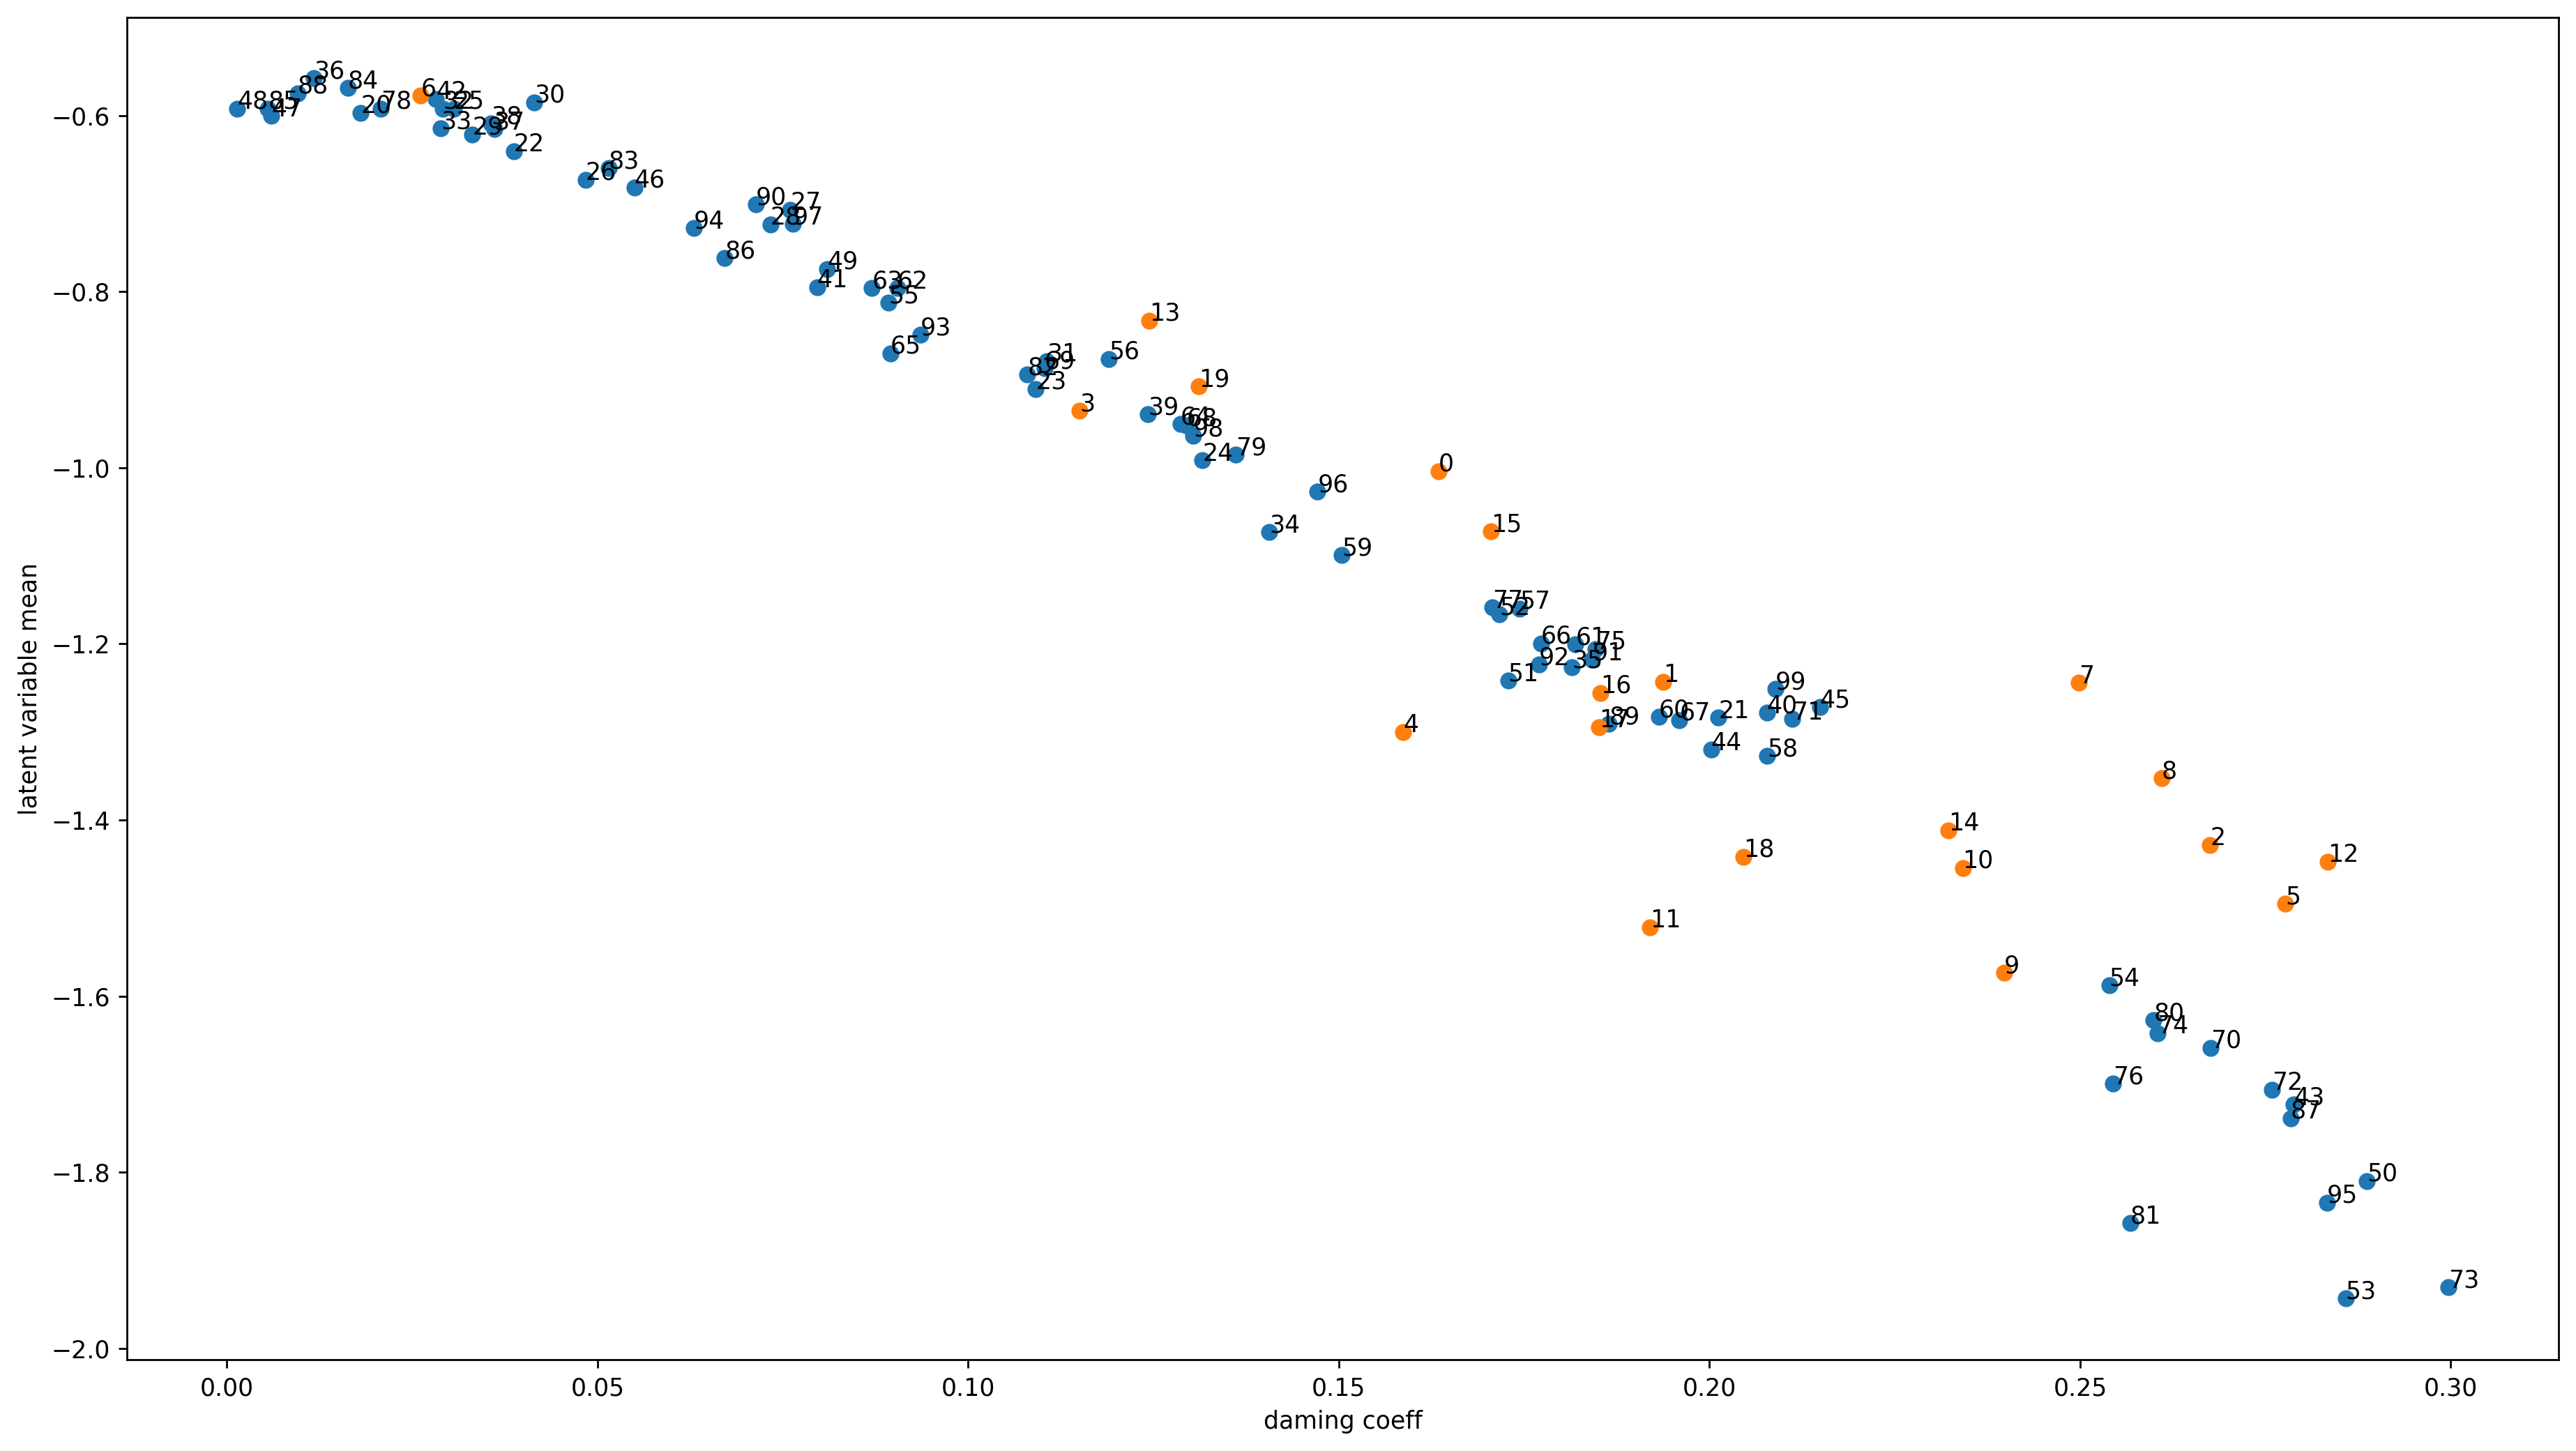

[0.16346495 0.19376823 0.2675319  0.11503246 0.15866848 0.27767899
 0.02613879 0.24978595 0.26100364 0.23974757]
[0.23415875 0.19197631 0.28340068 0.12439858 0.23227011 0.17053018
 0.18529065 0.1850802  0.20454609 0.13110959]
[0.01806764 0.20119136 0.03867789 0.10911323 0.13158045 0.03061344
 0.04839286 0.07598748 0.07332768 0.03311254]
[0.04145489 0.11061755 0.02913038 0.02882952 0.14059536 0.18145366
 0.01175634 0.03605897 0.03561832 0.1242789 ]
[0.20774164 0.07961685 0.02818215 0.27878886 0.20022311 0.21489816
 0.05495741 0.00603226 0.00140864 0.08100239]
[0.28865656 0.1728472  0.17167557 0.2858247  0.2539226  0.08923109
 0.11895172 0.17438186 0.20775948 0.15039731]
[0.19319706 0.18191796 0.09047245 0.08702328 0.12863061 0.0894847
 0.17726183 0.19596025 0.12942553 0.11026856]
[0.26757701 0.21116658 0.27584478 0.2996541  0.26043782 0.18466787
 0.25440247 0.17073022 0.0207501  0.1360628 ]
[0.2599147  0.256741   0.10799342 0.0514889  0.0163014  0.00555654
 0.06717741 0.27842439 0.00955

In [5]:
plt.figure(figsize=(18,10), dpi=250)
np_mulogvar = iwvi.mulogvar_offlinedata.numpy()
plt.xlabel("daming coeff")
plt.ylabel("latent variable mean")

plt.plot(debug_info[iwvi.validdata_num:,1], np_mulogvar[iwvi.validdata_num:,0], "o")
plt.plot(debug_info[:iwvi.validdata_num,1], np_mulogvar[:iwvi.validdata_num,0], "o")
# plt.xlim([-0.05,0.35])
for i in range(len(debug_info)):
    plt.annotate(str(i), xy=(debug_info[i,1],  np_mulogvar[i,0]))
plt.savefig(figfilenamehead+"damping_latent_"+env_str+"_iter0.png")
plt.savefig(figfilenamehead+"damping_latent_"+env_str+"_iter0.eps")
# plt.savefig(figfilenamehead+"damping_latent_"+env_str+"_iter0.pdf")
plt.show()


for i in range(10):
    print(debug_info[i*10 : (i+1)*10,1])
# plt.show()
print("摩擦係数-潜在変数")

In [6]:
iwvi.get_real_rollout_bamdppolicy_data()


 0 1.1920928955078125e-06
c = 0.16346495489906906


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(done, (bool, np.bool8)):
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:141: UserWarning: WARN: The obs returned by the `step()` method was expecting numpy array dtype to be float32, actual type: float64
  logger.warn(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:165: UserWarning: WARN: The obs returned by the `step()` method is not within the observ


 1 4.334298849105835
c = 0.18566011168169722

 2 3.1512043476104736
c = 0.1683308328211557

 3 3.3543894290924072
c = 0.057584337703991816

 4 3.127079963684082
c = 0.27524366179915083

 5 3.132089376449585
c = 0.2989221284223956

 6 3.1871492862701416
c = 0.2227009124240138

 7 4.162079095840454
c = 0.11809930982839231

 8 3.194324493408203
c = 0.03994211814682793

 9 3.1453144550323486
c = 0.1264016204359847

 10 3.546091318130493
c = 0.16135990932394045

 11 3.4328339099884033
c = 0.19922339987098472

 12 3.3906967639923096
c = 0.14602576409771476

 13 3.2124576568603516
c = 0.02102724103975695

 14 3.0497207641601562
c = 0.05304082251549723

 15 3.054776668548584
c = 0.10198114800388415

 16 3.048114061355591
c = 0.0961930665712722

 17 3.1647744178771973
c = 0.21609207373202774

 18 4.340454339981079
c = 0.08863702472592401

 19 6.8233253955841064
c = 0.189539854904928

 20 6.612225532531738
c = 0.1879102290799519

 21 6.545491695404053
c = 0.04560711487510172

 22 6.743287086486

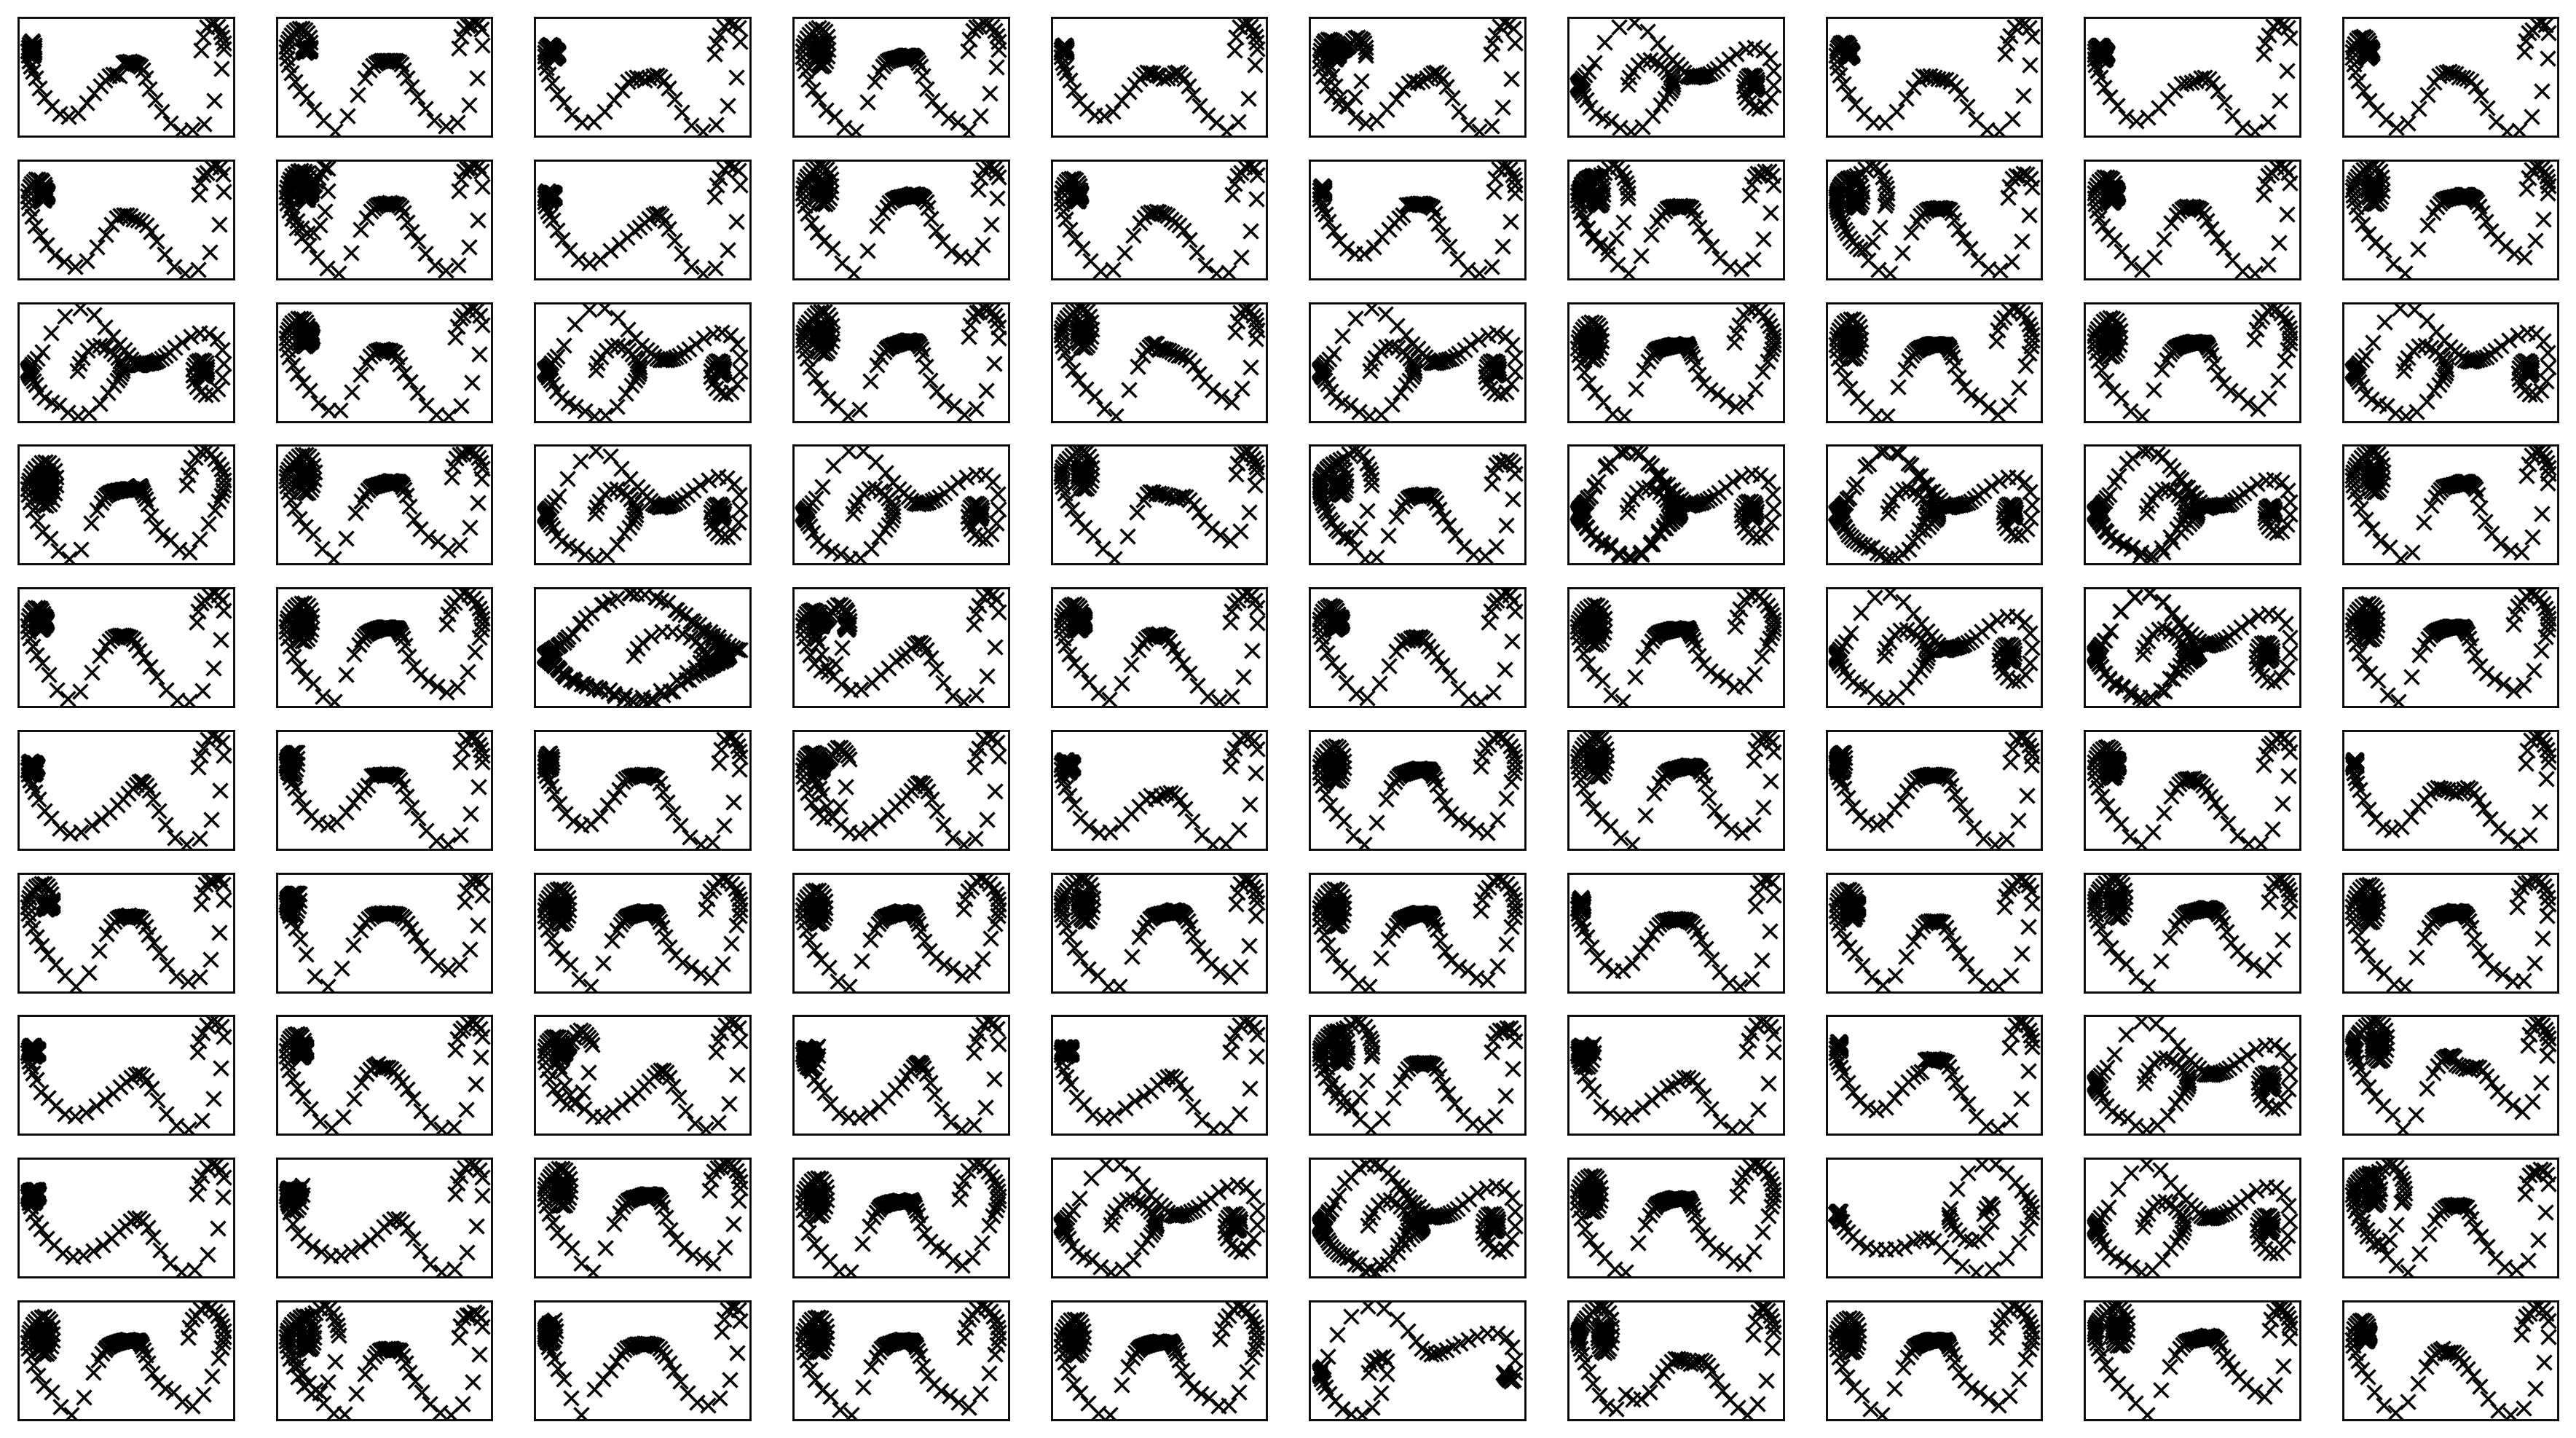

In [7]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx") 
plt.show()

In [8]:
iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)


 0 7.152557373046875e-07
c = 0.14392326383607168

 1 3.3623125553131104
c = 0.11344248659268091

 2 3.7713329792022705
c = 0.14758988962627198

 3 3.0434484481811523
c = 0.12569255853006872

 4 3.102149248123169
c = 0.14044656247209175

 5 3.046560764312744
c = 0.20906730223853984

 6 3.0223450660705566
c = 0.16000110169704337

 7 3.3061459064483643
c = 0.29081217398267006

 8 3.1575214862823486
c = 0.13797828223506528

 9 3.2123184204101562
c = 0.17127028229047328
predict diverge [ 12.75844192 870.5674337 ] sim_timestep 73

 10 1.145906925201416
c = 0.08920720161370395

 11 3.1882331371307373
c = 0.2883295404987869

 12 3.174966812133789
c = 0.2851149840772385

 13 3.045117139816284
c = 0.28165003349882545

 14 3.228440284729004
c = 0.12080130954975735

 15 3.1615068912506104
c = 0.2230001711843933

 16 3.145735502243042
c = 0.11624301678373404

 17 3.0900516510009766
c = 0.1785132499257869

 18 3.193889856338501
c = 0.29370016590926323

 19 3.210165500640869
c = 0.2462312133883939




 69 2.9710521697998047
c = 0.2958883362696954

 70 3.0412216186523438
c = 0.17685426583667072

 71 3.0148987770080566
c = 0.13314846499047364

 72 3.058291435241699
c = 0.1965711655181713

 73 3.09189510345459
c = 0.07814306476803613

 74 3.0615391731262207
c = 0.09479656653068222

 75 3.066504955291748
c = 0.2629651803636718

 76 3.117125988006592
c = 0.25701493039991774

 77 3.0721142292022705
c = 0.017540433293583745

 78 3.066723585128784
c = 0.20308061702074448

 79 3.206557273864746
c = 0.1984051504389701

 80 2.9898908138275146
c = 0.22211739553754747

 81 3.1696736812591553
c = 0.01037877716507144

 82 3.172417163848877
c = 0.11779734908199603

 83 3.2413480281829834
c = 0.015054606325210607

 84 3.314713716506958
c = 0.2129191358925711

 85 3.2444095611572266
c = 0.299736707271583

 86 3.5620241165161133
c = 0.18376012591301003

 87 3.3990228176116943
c = 0.06839394836829131

 88 3.4354910850524902
c = 0.20676601222693572

 89 5.625847816467285
c = 0.09547352909153171

 90 5.

In [ ]:

fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
#     ax_list[-1].plot(iwvi.offline_data[i][:,0], iwvi.offline_data[i][:,1],"kx") 
#     ax_list[-1].plot(iwvi.simenv_rolloutdata[i][:,0], iwvi.simenv_rolloutdata[i][:,1],"o") 
    ax_list[-1].plot(simdata0a[i][:,0], simdata0a[i][:,1]) 
    ax_list[-1].plot(simdata0b[i][:,0], simdata0b[i][:,1]) 
#     ax_list[-1].plot(simdata0c[i][:,0], simdata0c[i][:,1]) 

    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx") 
plt.savefig(figfilenamehead+"iter0.png")
# plt.savefig(figfilenamehead+"iter0.pdf")
plt.savefig(figfilenamehead+"iter0.eps")
print("実環境方策rollout vs Sim環境方策rollout")

In [ ]:
print(datetime.datetime.now())